### IMPORTS

In [1]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch
from qwen_vl_utils import process_vision_info
import json
import pandas as pd
from tqdm import tqdm

### Loading model and processor

In [ ]:
# Load model and tokenizer
model_id = "Qwen/Qwen2.5-VL-3B-Instruct" # can be changed to 7B model
model = AutoModelForImageTextToText.from_pretrained(
    model_id, 
    device_map="auto", 
    torch_dtype=torch.bfloat16
)
processor = AutoProcessor.from_pretrained(model_id)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# using adapter
adapter_path = "adapter_path"
model.load_adapter(adapter_path)

In [ ]:
from datasets import load_from_disk

# dataset loading - this dataset was created during the fine-tuning process
hf_dataset = load_from_disk('dataset_path')

In [5]:
# Split dataset based on the "split" column
train_dataset = hf_dataset.filter(lambda x: x["split"] == "train")
test_dataset = hf_dataset.filter(lambda x: x["split"] == "test")
val_dataset = hf_dataset.filter(lambda x: x["split"] == "val")

# Remove the "split" column as it's no longer needed
train_dataset = train_dataset.remove_columns("split")
test_dataset = test_dataset.remove_columns("split")
val_dataset = val_dataset.remove_columns("split")

In [6]:
system_message = """You are a Vision-Language Model specialized in OCR for multilingual images, primarily containing typewritten text in Ukrainian, Russian, and other languages.  

Your task is to:  
1. **Extract all text** from the provided image with high accuracy.  

Respond concisely in a structured format, providing:  
- The full extracted text  

Focus on precision, ensuring the output reflects the text in the image. Avoid unnecessary explanations or interpretations beyond the detected content."""

user_prompt = """Perform OCR on the provided image containing typewritten multilingual text (primarily Ukrainian, Russian, and other languages).  
Extract and transcribe all text from the entire scanned document accurately.  

Return the output in a structured JSON format with the following key:  
- `"qwen_ocr_text"`: The complete transcribed text from the document  

Ensure high accuracy in text extraction. Do not include unnecessary explanations in the response.
"""  

def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": user_prompt,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": json.dumps(sample['label'], indent=2, ensure_ascii=False)}],
        },
    ]

In [9]:
train_dataset = [format_data(sample) for sample in train_dataset]
val_dataset = [format_data(sample) for sample in val_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [10]:
# this will be sent to model
train_dataset[0][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision-Language Model specialized in OCR for multilingual images, primarily containing typewritten text in Ukrainian, Russian, and other languages.  \n\nYour task is to:  \n1. **Extract all text** from the provided image with high accuracy.  \n\nRespond concisely in a structured format, providing:  \n- The full extracted text  \n\nFocus on precision, ensuring the output reflects the text in the image. Avoid unnecessary explanations or interpretations beyond the detected content.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=434x64>},
   {'type': 'text',
    'text': 'Perform OCR on the provided image containing typewritten multilingual text (primarily Ukrainian, Russian, and other languages).  \nExtract and transcribe all text from the entire scanned document accurately.  \n\nReturn the output in a structured JSON format with the following 

In [11]:
# generate function - prepares all necessary data for the inference
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2], tokenize=False, add_generation_prompt=True  # Use the sample without the system message
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens, temperature=0.1)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

Model Prediction:  {'qwen_ocr_text': '5. Мылом по'}
Truth Data:  {'qwen_ocr_text': '5. Мылом по'}


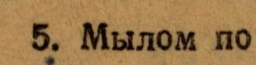

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': '4. Сахаром по-'}
Truth Data:  {'qwen_ocr_text': '4. Сахаром по'}


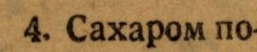

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': '3. Выдано талонов на питание.'}
Truth Data:  {'qwen_ocr_text': '3. Выдано талонов на питание'}


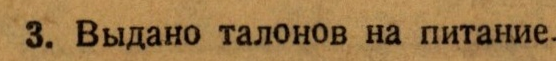

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': '2. Сухим пайком на путь следования на'}
Truth Data:  {'qwen_ocr_text': '2. Сухим пайком на путь следования на'}


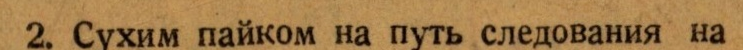

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': '1. Продовольствием в натуре по'}
Truth Data:  {'qwen_ocr_text': '1. Продовольствием в натуре по'}


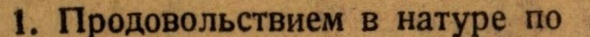

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'Номер и дата документа'}
Truth Data:  {'qwen_ocr_text': 'Номер и дата документа'}


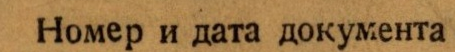

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'Без подписей и гербовой печати, а также без предъявления документа, подтверждающего нахождение военнослужащего вне пределов части, аттестат недействителен. За подделку аттестата виновные подвергаются ответственности по суду.'}
Truth Data:  {'qwen_ocr_text': 'Без подписей и гербовой печати, а также без предъявления документа, подтверждающего нахождение военнослужащего вне пределов части, аттестат недействителен. За подделку аттестата виновные подвергаются ответственности по суду.'}


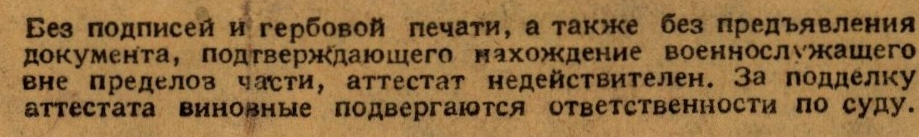

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'Руководствуясь ст. ст. 93 п. 2 и 108 УПК УССР.'}
Truth Data:  {'qwen_ocr_text': 'Руководствуясь ст. ст. 93 п. 2 и 108 УПК УССР.'}


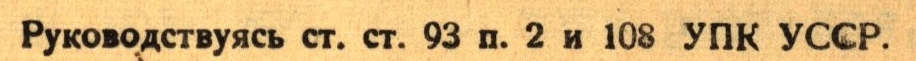

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'Отдела УМГБ Закарпатской области'}
Truth Data:  {'qwen_ocr_text': 'Отдела УМГБ Закарпатской области'}


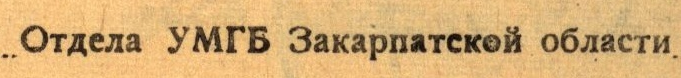

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'и найдя, что'}
Truth Data:  {'qwen_ocr_text': 'и найдя, что'}


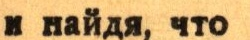

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'Копией настоящего постановления уведомить Областного прокурора и Отдел "А" УМГБ З. О.'}
Truth Data:  {'qwen_ocr_text': 'Копией настоящего постановления уведомить прокурора и Отдел "А" УМГБ З. О.'}


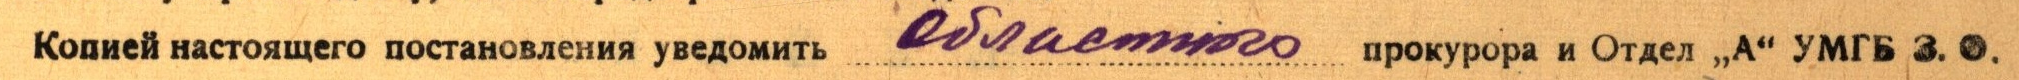

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'С какого времени и где содержится под стражей'}
Truth Data:  {'qwen_ocr_text': 'С какого времени и где содержится под стражей'}


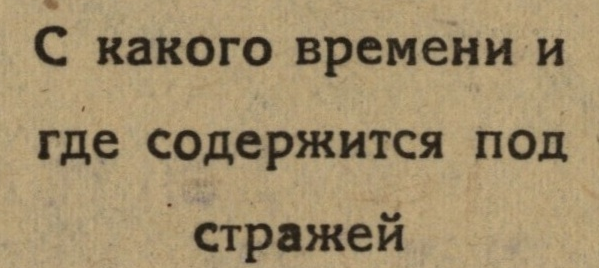

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'Фамилия докладчика и должность'}
Truth Data:  {'qwen_ocr_text': 'Фамилия докладчика и должность'}


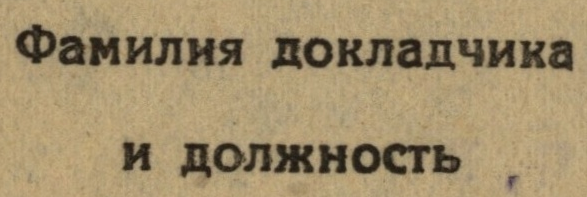

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'года рождения, осужденного Особым Совещанием'}
Truth Data:  {'qwen_ocr_text': 'года рождения, осужденного Особым Совещанием'}


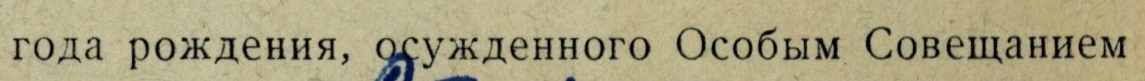

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'смотрев поступившие материалы о преступной деятельности: Имя и отчество МИЦОВДА род рождения место рожд. село Заусино, Велико-Березненского округа З.О. профессия и специальность не имеет место работы и должность крестьяника в своем хозяйстве парт. образование 8 классов нац. украинка гр-во СССР семейное положение не замужняя.'}
Truth Data:  {'qwen_ocr_text': 'Рассмотрев поступившие материалы о преступной деятельности: Фамилия МИЦОВДА Имя и отчество Мария Михайловна Год рождения І930 место рожд. село Заусино, Велико-Березненского округа З. О. Профессия и специальность не имеет Место работы и должность крестьянка в своем хозяйстве парт. Образование 8 классов нац. украинка гр-во СССР Семейное положение не замужняя.'}


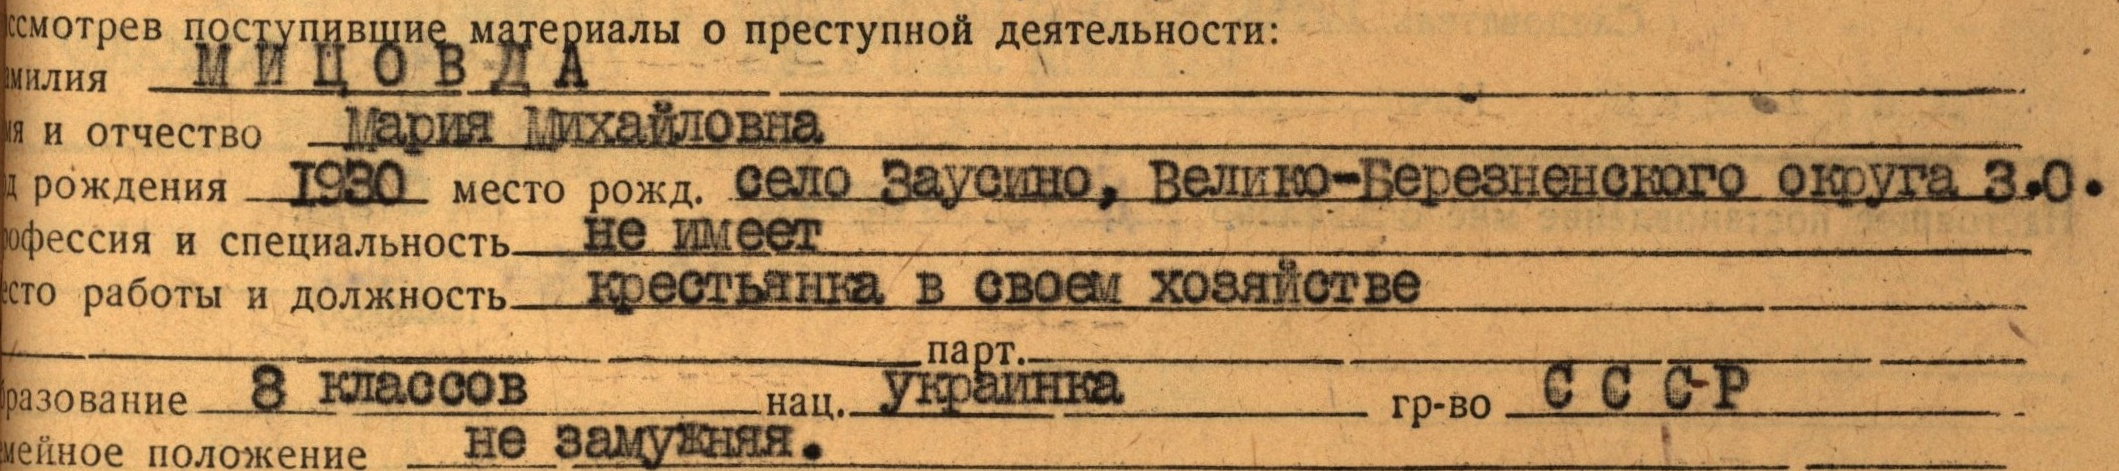

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': '6. Нац. и гражд. (подданство)'}
Truth Data:  {'qwen_ocr_text': '6. Нац. и гражд. (подданство)'}


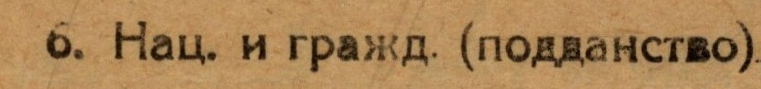

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': '8. Род занятий'}
Truth Data:  {'qwen_ocr_text': '8. Род занятий'}


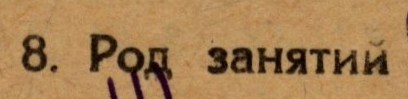

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': '9. Социальное происхождение'}
Truth Data:  {'qwen_ocr_text': '9. Социальное происхождение'}


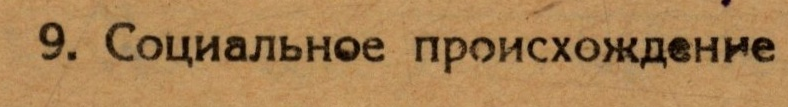

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': '(род занятий родителей и их имущественное положение)'}
Truth Data:  {'qwen_ocr_text': '(род занятий родителей и их имущественное положение)'}


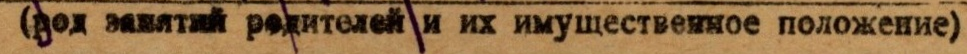

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': '10. Социальное положение (род занятий и имущественное положение)'}
Truth Data:  {'qwen_ocr_text': '10. Социальное положение (род занятий и имущественное положение)'}


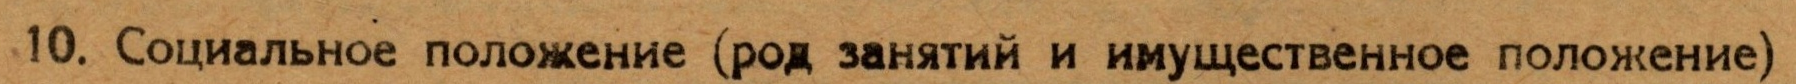

----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'а) до революции'}
Truth Data:  {'qwen_ocr_text': 'а) до революции'}


----------------------------------------------------------------------------------------------------
Model Prediction:  {'qwen_ocr_text': 'б) после революции'}
Truth Data:  {'qwen_ocr_text': 'б) после революции'}


----------------------------------------------------------------------------------------------------


In [13]:
for i in range(0, len(test_dataset)-1):
    output = generate_text_from_sample(model, processor, test_dataset[i])
    
    print('Model Prediction: ', eval(output))
    print('Truth Data: ', eval(test_dataset[i][2]['content'][0]['text']))
    display(test_dataset[i][1]['content'][0]['image'])
    print('-'*100)
    if i > 20:
        break
        